In [57]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

## Load data 

In [58]:
df = pd.read_csv('./VAR_preds_for_crisis_months.csv', converters={'ags2': str, 'ags5': str} )
#df.set_index('ags5', drop=True, inplace=True)
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

## Plot ground truth vs pred

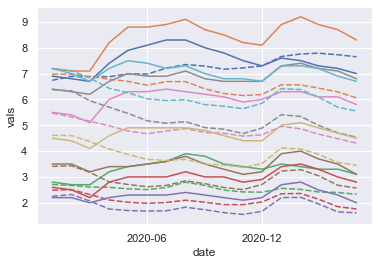

In [50]:
df_long = df.melt(id_vars=['date','ags5'], var_name='y_type', value_name='vals')
sample_args = random.sample(list(set(df_long['ags5'])), 10)
df_sample = df_long[df_long['ags5'].isin(sample_args)]
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

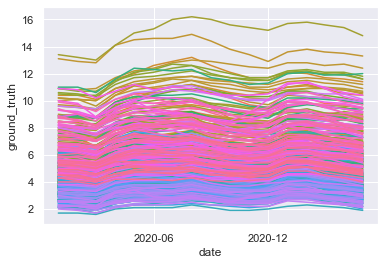

In [51]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

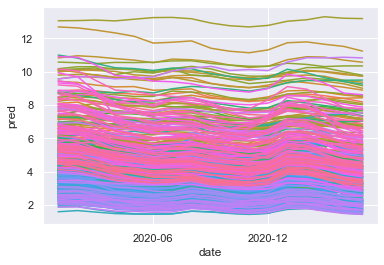

In [52]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Look into errors

In [63]:
df['error'] = (df['ground_truth']-df['pred'])/df['pred']

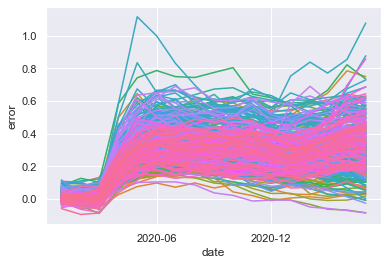

In [64]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Look into mean errors


In [65]:
df_mean_error = df.groupby(['ags5']).mean()
df_mean_error   

,ground_truth,pred,error
ags5,,,
01001,9.094118,7.798235,0.168296
01002,8.517647,7.147059,0.193707
01003,8.323529,6.834118,0.221480
01004,9.088235,7.341176,0.243160
01051,6.235294,5.051765,0.245177
...,...,...,...
16073,6.005882,4.757059,0.271512
16074,4.641176,3.697059,0.268903
16075,4.982353,3.900588,0.293622


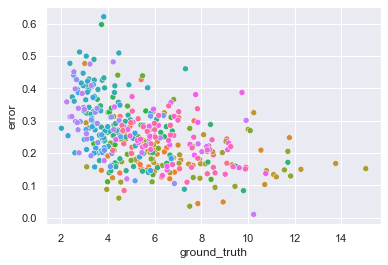

In [66]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

In [67]:
df_mean_error.sort_values(by=['error'], ascending=False)

,ground_truth,pred,error
ags5,,,
09180,3.823529,2.422941,0.621183
07141,3.729412,2.372353,0.597062
09174,2.788235,1.855882,0.511960
09172,4.470588,3.042941,0.508944
09181,3.076471,2.077059,0.499209
...,...,...,...
05566,4.470588,4.220000,0.060244
03402,8.935294,8.528824,0.048266
03354,7.852941,7.536471,0.043417


# Load structural data

In [68]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )

df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


In [71]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5'])
list(df_mixed.columns)

['ags5',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'ags2',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Sequential Feature Selector


In [74]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

regr = LinearRegression()
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [75]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(152,)","[-0.15127424441937976, -0.04607565183767748, 0...",-0.007414,"(debtor_quota,)",0.118839,0.092461,0.046231
2,"(152, 168)","[-0.09713181894340184, 0.003156829598385369, 0...",0.032043,"(debtor_quota, metropolitan_area)",0.098244,0.076438,0.038219
3,"(25, 152, 168)","[-0.08086297324508429, 0.03276363722111486, 0....",0.054281,"(kilometers_per_person_and_day, debtor_quota, ...",0.101715,0.079138,0.039569
4,"(25, 117, 152, 168)","[-0.11141885550252573, 0.039417246551306184, 0...",0.067733,"(kilometers_per_person_and_day, no_of_tourism_...",0.132379,0.102995,0.051498
5,"(4, 25, 117, 152, 168)","[-0.11474587315603402, 0.05176664940118747, 0....",0.082091,"(average_distance_train_station, kilometers_pe...",0.148289,0.115374,0.057687
6,"(4, 25, 117, 152, 168, 571)","[-0.14113328166267514, 0.19692008467047928, 0....",0.13186,"(average_distance_train_station, kilometers_pe...",0.197363,0.153555,0.076778
7,"(4, 25, 67, 117, 152, 168, 571)","[-0.17733204544473002, 0.20610289069300725, 0....",0.149345,"(average_distance_train_station, kilometers_pe...",0.236422,0.183945,0.091972
8,"(4, 25, 67, 117, 152, 168, 487, 571)","[-0.1268553931916354, 0.17551678564321238, 0.3...",0.15754,"(average_distance_train_station, kilometers_pe...",0.210336,0.163648,0.081824
9,"(4, 25, 67, 117, 152, 168, 487, 571, 592)","[-0.12082708476933957, 0.18411252061436123, 0....",0.163859,"(average_distance_train_station, kilometers_pe...",0.215393,0.167583,0.083792
10,"(4, 25, 67, 117, 152, 168, 487, 571, 573, 592)","[-0.12082708476933957, 0.16868476600148385, 0....",0.168993,"(average_distance_train_station, kilometers_pe...",0.219759,0.17098,0.08549


In [76]:
list(summary_table_select['feature_names'])[:5]

[('debtor_quota',),
 ('debtor_quota', 'metropolitan_area'),
 ('kilometers_per_person_and_day', 'debtor_quota', 'metropolitan_area'),
 ('kilometers_per_person_and_day',
  'no_of_tourism_points',
  'debtor_quota',
  'metropolitan_area'),
 ('average_distance_train_station',
  'kilometers_per_person_and_day',
  'no_of_tourism_points',
  'debtor_quota',
  'metropolitan_area')]